In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

In [4]:
def NMSE_to_RMSE(scores):
    #change negative mean square error to root mean square error
    scores_new = scores.copy()
    scores_new['train_score'] = np.sqrt(-scores['train_score']).copy()
    scores_new['test_score'] = np.sqrt(-scores['test_score']).copy()
    return scores_new

def display_scores(scores, NMSE = False):
    if NMSE:
        scores_new = NMSE_to_RMSE(scores)
    print("CV Train Scores:", scores_new['train_score'])
    print("CV Train Mean:",scores_new['train_score'].mean())
    print("CV Train Standard Deviation:", scores_new['train_score'].std())
    print("")
    print("CV Validation Scores:", scores_new['test_score'])
    print("CV Validation Mean:", scores_new['test_score'].mean())
    print("CV Validation Standard Deviation:", scores_new['test_score'].std())

In [5]:
def create_submission(test_x, test_y, filename):
    sub_folder = "../submissions/"
    submission = pd.DataFrame(test_y, columns=['SalePrice'])
    submission['Id'] = test_X['Id'].astype(int).copy()
    submission.to_csv(sub_folder + filename, index=False)

In [6]:
train = pd.read_csv("../data/train.csv")
test_X = pd.read_csv('../data/test.csv')

In [7]:
train_Y = train['SalePrice'].copy()
train_X = train.drop(['SalePrice'],axis=1).copy()

In [8]:
train_X.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

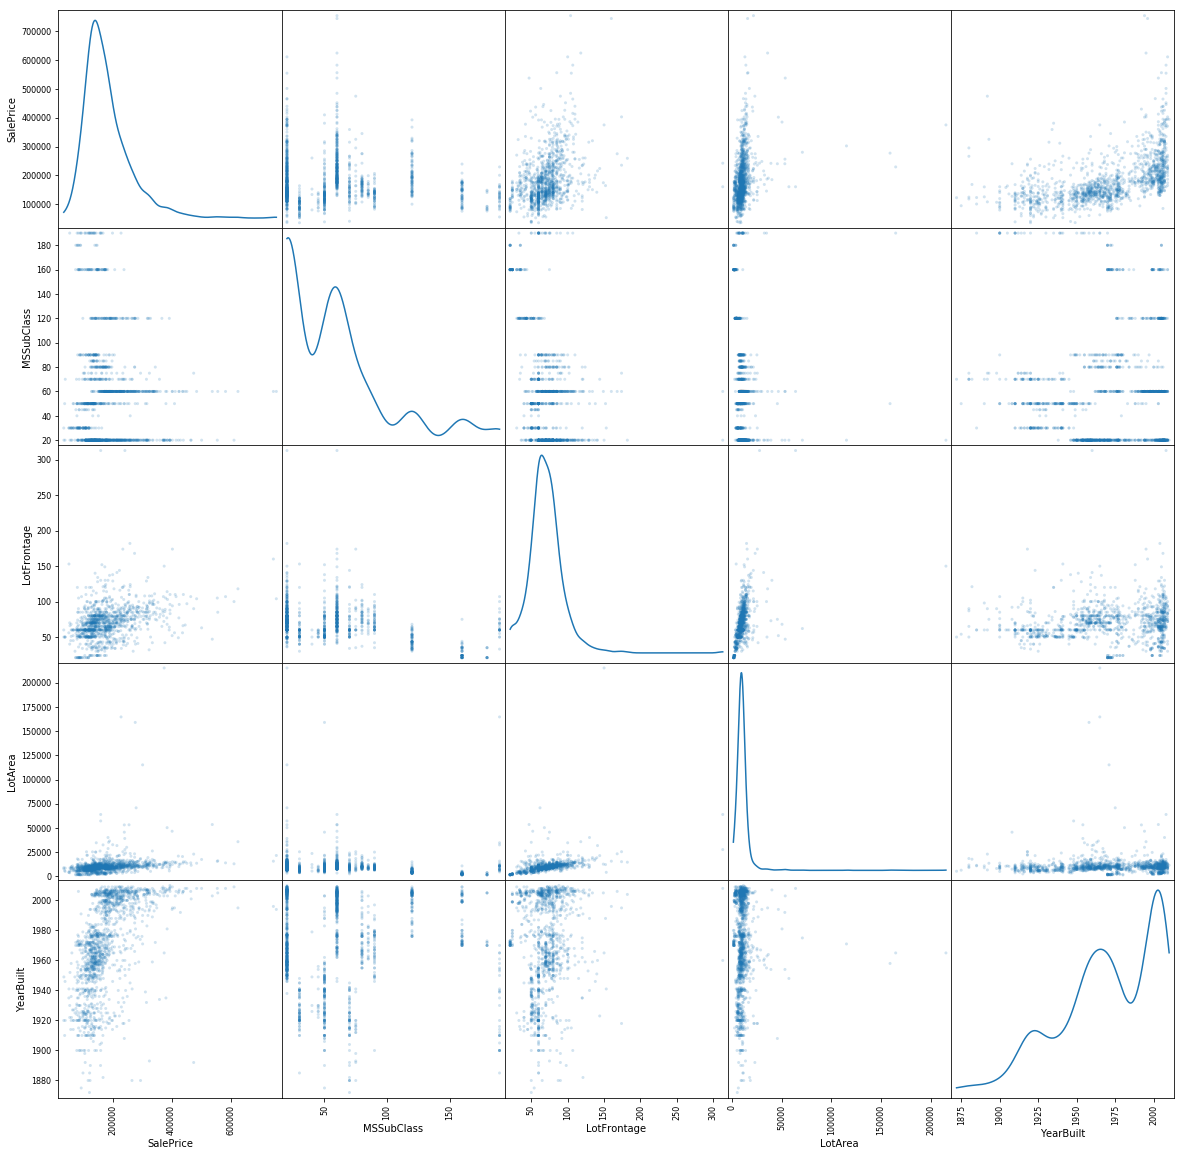

In [9]:
plot_thingy = train[['SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt']];
scatter_matrix(plot_thingy, alpha=0.2, figsize=(20, 20), diagonal='kde');

In [10]:
class Drop_Cats(TransformerMixin):
    def _init_(self):
        pass
    def fit(self, X, y=None):
        return self    
    def transform(self, X, y=None):
        X = X.select_dtypes(include=[np.number])
        return X
    
class Drop_ID(TransformerMixin):
    def _init_(self):
        pass
    def fit(self, X, y=None):
        return self    
    def transform(self, X, y=None):
        X = X.drop(['Id'], axis=1)
        return X

In [11]:
class ColSaver(TransformerMixin):
    #saves the column names that will be lost when working with numpy arrays
    def _init_(self):
        self.columns
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    def transform(self, X, y=None):
        return X

In [12]:
# class lnify(TransformerMixin):
#     def _init_(self):
#         self.trans_columns
#     def fit(self, X, y=None):
#         X = pd.DataFrame(X)
#         A = X.skew()>5
#         self.trans_columns = A.index[A]
#         return self
#     def transform(self, X, y=None):
#         X = pd.DataFrame(X)
#         Q = X[self.trans_columns].copy()
#         Q = np.log1p(Q)
#         X[self.trans_columns] = Q
#         return X

In [13]:
model = LinearRegression()

In [14]:
my_pipeline = Pipeline(steps = [
    ('Drop_Cats', Drop_Cats()),
    ('Drop_ID', Drop_ID()),
    ('ColSaver',ColSaver()),
    ('imputer', Imputer(strategy='mean')),
    ('std_scalar', StandardScaler()),
#     ('LN', lnify()),
    ('model', model)
])

train_Y is skewed and ln helps, and the kaggle scoring method is based on LN(y)

In [15]:
print('RMS ln(E)')
q = cross_validate(my_pipeline, train_X,  np.log1p(train_Y), cv=5, scoring = 'neg_mean_squared_error', 
                   n_jobs=-1, return_train_score=True)
display_scores(q, NMSE = True)

RMS ln(E)
CV Train Scores: [0.14822093 0.14110083 0.146202   0.14914598 0.13309687]
CV Train Mean: 0.14355332136662802
CV Train Standard Deviation: 0.005923376132340609

CV Validation Scores: [0.13392876 0.1626281  0.14319209 0.12906187 0.20510703]
CV Validation Mean: 0.15478356961186848
CV Validation Standard Deviation: 0.02765819198973969


In [16]:
my_pipeline.fit(train_X, np.log1p(train_Y));

In [17]:
train_Y_predict = np.expm1(my_pipeline.predict(train_X))
test_Y_predict = np.expm1(my_pipeline.predict(test_X))
create_submission(test_X, test_Y_predict, 'House Prices Sumbission - linear reg pipeline CV and log1p.csv')

In [18]:
#Kaggle test score of 0.14149 on public leaderboard

Text(0.5,1,'Train Y vs straight line')

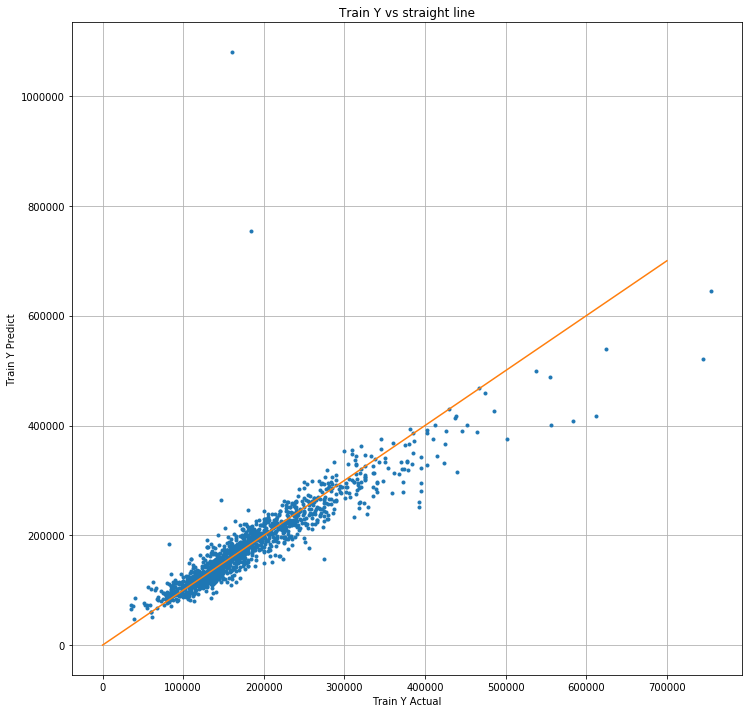

In [19]:
plt.figure(figsize=(12, 12))
plt.grid()
plt.plot(train_Y,train_Y_predict, '.')
plt.plot(range(0,800000,100000), range(0,800000,100000))

plt.xlabel('Train Y Actual')
plt.ylabel('Train Y Predict')
plt.title('Train Y vs straight line')

Text(0.5,1,'Train Y vs error')

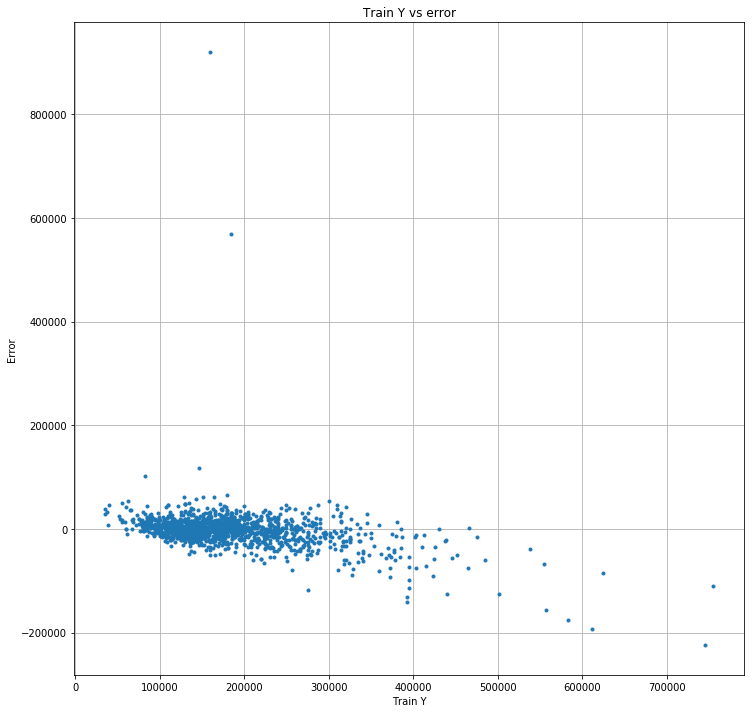

In [20]:
plt.figure(figsize=(12, 12))
plt.grid()
plt.plot(train_Y,train_Y_predict - train_Y, '.')
plt.xlabel('Train Y')
plt.ylabel('Error')
plt.title('Train Y vs error')

In [21]:
#whats with these two outliers with the huge errors??? 
pd.set_option("display.max_columns", None)
train_outliers = train_X[train_Y_predict>700000]
train_outliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial


In [22]:
pd.DataFrame(data=my_pipeline.named_steps['std_scalar'].mean_, 
                   index=my_pipeline.named_steps['ColSaver'].columns,
                   columns=['Mean']).transpose()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Mean,56.89726,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.95411,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753


In [23]:
train_X.groupby(['SaleCondition']).size()

SaleCondition
Abnorml     101
AdjLand       4
Alloca       12
Family       20
Normal     1198
Partial     125
dtype: int64

In [24]:
#the outliers look relativly big compared to the average square footage measures and number of rooms. 
# and they are "partial" sales. lets remove them and retrain
train_X = train_X.drop(train_outliers.index.tolist())
train_Y = train_Y.drop(train_outliers.index.tolist())

In [25]:
print('RMS ln(E)')
q = cross_validate(my_pipeline, train_X,  np.log1p(train_Y), cv=5, scoring = 'neg_mean_squared_error', 
                   n_jobs=-1, return_train_score=True)
display_scores(q, NMSE = True)

RMS ln(E)
CV Train Scores: [0.12392155 0.12286928 0.12171705 0.1251859  0.12367639]
CV Train Mean: 0.12347403383757231
CV Train Standard Deviation: 0.0011510373308697725

CV Validation Scores: [0.12649557 0.13280783 0.13509342 0.12063962 0.12965815]
CV Validation Mean: 0.1289389199757787
CV Validation Standard Deviation: 0.005063832110331002


In [26]:
#better results without the 2 outliers

In [27]:
my_pipeline.fit(train_X, np.log1p(train_Y));
train_Y_predict = np.expm1(my_pipeline.predict(train_X))
test_Y_predict = np.expm1(my_pipeline.predict(test_X))
create_submission(test_X, test_Y_predict, 'House Prices Sumbission - linear reg pipeline CV log1p and no out.csv')

In [28]:
#public score of 0.13404

Text(0.5,1,'Train Y vs straight line')

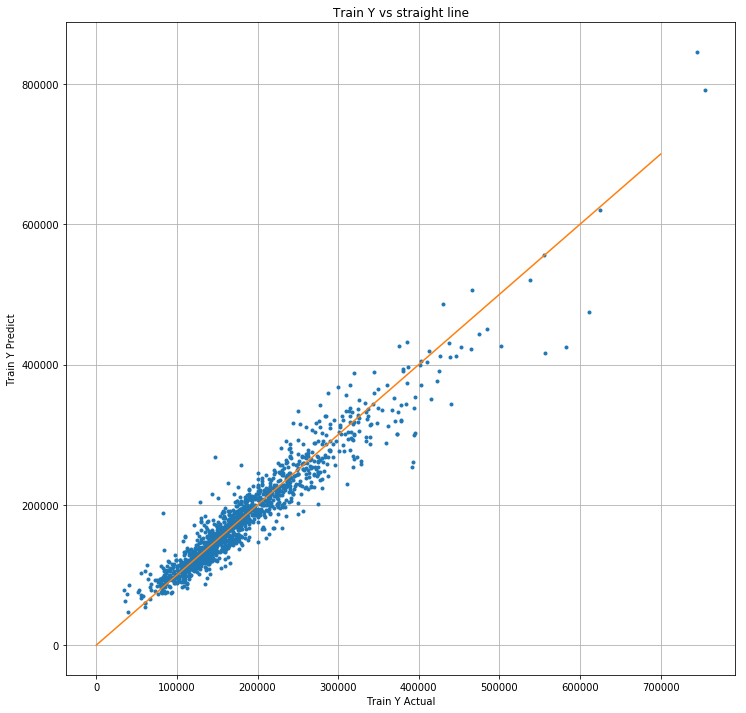

In [29]:
plt.figure(figsize=(12, 12))
plt.grid()
plt.plot(train_Y,train_Y_predict, '.')
plt.plot(range(0,800000,100000), range(0,800000,100000))

plt.xlabel('Train Y Actual')
plt.ylabel('Train Y Predict')
plt.title('Train Y vs straight line')

Text(0.5,1,'Train Y vs error')

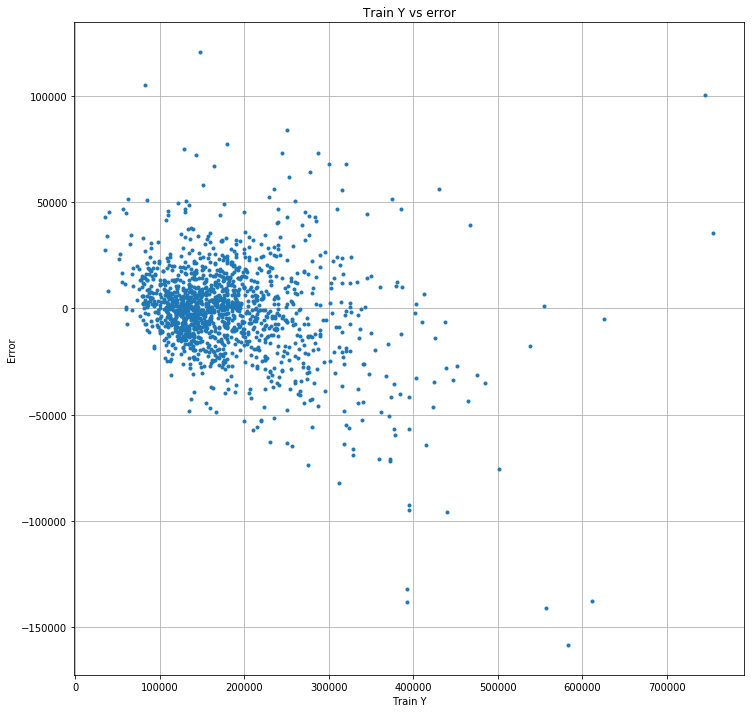

In [30]:
plt.figure(figsize=(12, 12))
plt.grid()
plt.plot(train_Y,train_Y_predict - train_Y, '.')
plt.xlabel('Train Y')
plt.ylabel('Error')
plt.title('Train Y vs error')

In [31]:
print('Average error on train is {0}, compared to average price of {1}.'.
      format(round((train_Y_predict - train_Y).mean()), round(train_Y.mean())))

Average error on train is -1185, compared to average price of 180933.


In [32]:
pd.DataFrame(data=model.coef_, 
             index=my_pipeline.named_steps['ColSaver'].columns, 
             columns=['Coeff'] ).transpose()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Coeff,-0.014737,0.014219,0.021944,0.100444,0.05663,0.09164,0.02417,-0.00007,-2.117578e+11,-7.894811e+10,-2.162173e+11,2.029607e+11,2.750751e+11,3.219397e+11,3.597479e+10,-3.755105e+11,0.014507,-0.000324,0.010315,0.008349,-0.01244,-0.013611,0.016747,0.021816,-0.001661,0.026291,0.017761,0.009781,0.002993,0.007322,0.004205,0.014816,-0.000699,-0.003235,0.000287,-0.00818


In [33]:
#the area features have really positive or really negative slopes. 
#they are probably highly correlated. lets see what happens with lasso

In [34]:
model = Lasso(alpha = 0.1)

In [35]:
my_pipeline = Pipeline(steps = [
    ('Drop_Cats', Drop_Cats()),
    ('Drop_ID', Drop_ID()),
    ('ColSaver',ColSaver()),
    ('imputer', Imputer(strategy='mean')),
    ('std_scalar', StandardScaler()),
#     ('LN', lnify()),
    ('model', model)
])

In [36]:
print('RMS ln(E)')
q = cross_validate(my_pipeline, train_X,  np.log1p(train_Y), cv=5, scoring = 'neg_mean_squared_error', 
                   n_jobs=-1, return_train_score=True)
display_scores(q, NMSE = True)

RMS ln(E)
CV Train Scores: [0.20727849 0.20708271 0.20577103 0.2070069  0.20618052]
CV Train Mean: 0.206663933241702
CV Train Standard Deviation: 0.0005833777817902014

CV Validation Scores: [0.20175143 0.22504189 0.2182771  0.19592481 0.19495334]
CV Validation Mean: 0.20718971423911098
CV Validation Standard Deviation: 0.012229734907514512


In [37]:
#that doesnt look so good

In [38]:
model = LassoCV(cv=5)

In [39]:
my_pipeline = Pipeline(steps = [
    ('Drop_Cats', Drop_Cats()),
    ('Drop_ID', Drop_ID()),
    ('ColSaver',ColSaver()),
    ('imputer', Imputer(strategy='mean')),
    ('std_scalar', StandardScaler()),
#     ('LN', lnify()),
    ('model', model)
])

In [40]:
my_pipeline.fit(train_X, np.log1p(train_Y));
train_Y_predict = np.expm1(my_pipeline.predict(train_X))

In [41]:
model.alpha_

0.002854632573568328

In [42]:
#alpha = 0.00258 is close to regular linear reg.
test_Y_predict = np.expm1(my_pipeline.predict(test_X))
create_submission(test_X, test_Y_predict, 'House Prices Sumbission - lassoCV a= 0.00285')

In [43]:
#kaggle score of 0.13494, slightly worse than linear reg. with an alpha that small it should be close to linear reg

In [44]:
pd.DataFrame(data=model.coef_, 
             index=my_pipeline.named_steps['ColSaver'].columns, 
             columns=['Coeff'] ).transpose()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Coeff,-0.012169,0.01288,0.020385,0.104986,0.050791,0.084402,0.026189,0.0,0.031926,0.0,-0.0,0.046859,0.001562,0.0,-0.003502,0.129146,0.012912,-0.0,0.00525,0.005214,-0.001522,-0.011563,0.005209,0.02294,0.0,0.027776,0.018183,0.007968,0.001641,0.001395,0.001392,0.011328,-0.0,-0.0,0.0,-0.004899


In [45]:
# those coeffecients are much less extreme. not sure it matters though

In [46]:
#pd.DataFrame(data=model.mse_path_, index=model.alphas_) that doesn't measure the loss function the way I hoped it would

In [47]:
#now try with CATs

In [48]:
model=LinearRegression()

In [49]:
my_pipeline_with_cats = Pipeline(steps = [
#    ('Drop_Cats', Drop_Cats()),
    ('Drop_ID', Drop_ID()),
    ('CatergoricalEncoding', ce.OneHotEncoder()),
    ('ColSaver',ColSaver()),
    ('imputer', Imputer(strategy='mean')),
    ('std_scalar', StandardScaler()),
#     ('LN', lnify()),
    ('model', model)
])

In [50]:
print('RMS ln(E)')
q = cross_validate(my_pipeline_with_cats, train_X,  np.log1p(train_Y), cv=5, scoring = 'neg_mean_squared_error', 
                   n_jobs=-1, return_train_score=True)
# q = cross_validate(my_pipeline_with_cats, train_X,  np.log1p(train_Y), cv=5, scoring = 'neg_mean_squared_error', 
#                    n_jobs=-1, return_train_score=True)
display_scores(q, NMSE = True)

RMS ln(E)
CV Train Scores: [0.08852881 0.08615604 0.08569484 0.09006873 0.08907815]
CV Train Mean: 0.08790531242284098
CV Train Standard Deviation: 0.001696515865115254

CV Validation Scores: [3.14710718e+11 1.03296719e+12 7.15074826e+11 5.52859485e+11
 7.16771125e+11]
CV Validation Mean: 666476668743.9707
CV Validation Standard Deviation: 234884977702.01675


I overfit or broke something!!!!

In [51]:
model = LassoCV(cv=5)

In [52]:
my_pipeline_with_cats = Pipeline(steps = [
#    ('Drop_Cats', Drop_Cats()),
    ('Drop_ID', Drop_ID()),
    ('CatergoricalEncoding', ce.OneHotEncoder()),
    ('ColSaver',ColSaver()),
    ('imputer', Imputer(strategy='mean')),
    ('std_scalar', StandardScaler()),
#     ('LN', lnify()),
    ('model', model)
])

In [53]:
my_pipeline_with_cats.fit(train_X, np.log1p(train_Y))
train_Y_predict = np.expm1(my_pipeline_with_cats.predict(train_X))

In [54]:
pd.DataFrame(data=model.coef_, 
             index=my_pipeline_with_cats.named_steps['ColSaver'].columns, 
             columns=['Coeff'] ).transpose()

,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_-1,Street_0,Street_1,Street_-1,Alley_0,Alley_1,Alley_2,Alley_-1,LotShape_0,LotShape_1,LotShape_2,LotShape_3,LotShape_-1,LandContour_0,LandContour_1,LandContour_2,LandContour_3,LandContour_-1,Utilities_0,Utilities_1,Utilities_-1,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LotConfig_-1,LandSlope_0,LandSlope_1,LandSlope_2,LandSlope_-1,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Neighborhood_-1,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition1_-1,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,Condition2_-1,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,BldgType_-1,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,HouseStyle_-1,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofStyle_-1,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_-1,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior1st_-1,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Exterior2nd_-1,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,MasVnrType_4,MasVnrType_-1,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_-1,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,ExterCond_-1,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Foundation_-1,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtQual_-1,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtCond_-1,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtExposure_-1,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType1_-1,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,BsmtFinType2_-1,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Heating_-1,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,HeatingQC_-1,CentralAir_0,CentralAir_1,CentralAir_-1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,Electrical_5,Electrical_-1,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3,KitchenQual_-1,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,Functional_5,Functional_6,Functional_-1,FireplaceQu_0,FireplaceQu_1,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,FireplaceQu_5,FireplaceQu_-1,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,GarageType_-1,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageFinish_-1,GarageQual_0,GarageQual_1,GarageQual_2,GarageQual_3,GarageQual_4,GarageQual_5,GarageQual_-1,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,GarageCond_4,GarageCond_5,GarageCond_-1,PavedDrive_0,PavedDrive_1,PavedDrive_2,PavedDrive_-1,PoolQC_0,PoolQC_1,PoolQC_2,PoolQC_3,PoolQC_-1,Fence_0,Fence_1,Fence_2,Fence_3,Fence_4,Fence_-1,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,MiscFeature_-1,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleType_-1,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,

In [55]:
a = model.alpha_
print(a)

0.0037736562627514506


In [56]:
#my_pipeline_with_cats.fit(train_X, np.log1p(train_Y))
train_Y_predict = my_pipeline_with_cats.predict(train_X)
create_submission(test_X, test_Y_predict, 'House Prices Sumbission - Lasso alpha=0.00378 and CATs')

In [57]:
#scored 0.13494, which is exactly the same as lasso without CATs

In [58]:
model=Lasso(alpha=a)

my_pipeline_with_cats = Pipeline(steps = [
#    ('Drop_Cats', Drop_Cats()),
    ('Drop_ID', Drop_ID()),
    ('CatergoricalEncoding', ce.OneHotEncoder()),
    ('ColSaver',ColSaver()),
    ('imputer', Imputer(strategy='mean')),
    ('std_scalar', StandardScaler()),
#     ('LN', lnify()),
    ('model', model)
])

print('RMS ln(E)')
q = cross_validate(my_pipeline_with_cats, train_X,  np.log1p(train_Y), cv=10, scoring = 'neg_mean_squared_error', 
                   n_jobs=-1, return_train_score=True)
# q = cross_validate(my_pipeline_with_cats, train_X,  np.log1p(train_Y), cv=5, scoring = 'neg_mean_squared_error', 
#                    n_jobs=-1, return_train_score=True)
display_scores(q, NMSE = True)

RMS ln(E)
CV Train Scores: [0.09826354 0.09991079 0.09962166 0.09655012 0.09573294 0.09988506
 0.09860698 0.10033642 0.10071695 0.09709736]
CV Train Mean: 0.09867218234882537
CV Train Standard Deviation: 0.0016325160220053141

CV Validation Scores: [0.11201714 0.09546043 0.10597018 0.12477537 0.13972796 0.09847073
 0.11594059 0.09657518 0.08781833 0.12432476]
CV Validation Mean: 0.11010806732081595
CV Validation Standard Deviation: 0.015425041856743265


In [59]:
#it's a little suprising how far off my validation error and my kaggle score are
#maybe it is time to try some real feature engineering and/or non-linear models
#right now I am number 1723 out of 5035 on the leaderboard.